In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import geopandas
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [100]:
# Import annual hate crime incidents table
years = np.linspace(2005, 2020, 16, dtype=int).tolist()
offenses =[]
for y in years:
    n = y - 2005
    offenses_path='./offenses_csv/%s.csv'%(y)
    offenses.append(pd.read_csv(offenses_path, thousands=','))
    
    # Add Year column
    offenses[n]['Year'] = y

# Combine all years' incidents data
table_off = pd.concat(offenses)

# Drop details because we only care about total
table_off = table_off[table_off['Agency type'] == 'Total']
table_off = table_off.drop(columns=['Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Agency name', 'Agency type',
'1st\r\nquarter', '2nd\r\nquarter', '3rd\r\nquarter', '4th\r\nquarter','Unnamed: 3', 'Unnamed: 9', 'No. of\r\nquarters\r\nreported', 'Agency unit', 'Population1'])

# Replace NaNs with zeros
table_off = table_off.replace(np.nan,0)

# Replace exisiting str zero with float
cat_list=['Race', 'Religion', 'Sexual_orientation', 'Ethnicity', 'Disability', 'Gender', 'Gender_identity', 'Race/Ethnicity/Ancestry']
table_off[cat_list] = table_off[cat_list].astype(int)

# Add up total incidents
table_off['Incidents'] = 0
for c in cat_list:
    table_off['Incidents'] += table_off[c]

# Get rid of categories because we only care about total
table_off = table_off.drop(columns=cat_list)

# Clean State format
table_off['State'] = table_off['State'].str.capitalize()
table_off['Year'] = table_off['Year'].astype(str)
table_off = table_off.reset_index(drop=True)
table_off

,Year,State,Incidents
0,2006,Alabama,1
1,2006,Alaska,6
2,2006,Arizona,149
3,2006,Arkansas,113
4,2006,California,1297
...,...,...,...
742,2020,Virginia,170
743,2020,Washington,462
744,2020,West virginia,54
745,2020,Wisconsin,72


In [101]:
pop1 = pd.read_csv('./pop1.csv', thousands=',')

# Trun wide df to tidy
pop1 = pd.melt(pop1, id_vars=['State'], value_vars=pop1.columns[1:], var_name='Year', value_name='Population')
pop1

,State,Year,Population
0,Alabama,2010,4779736
1,Alaska,2010,710231
2,Arizona,2010,6392017
3,Arkansas,2010,2915918
4,California,2010,37253956
...,...,...,...
567,Washington,2020,7693612
568,West Virginia,2020,1784787
569,Wisconsin,2020,5832655
570,Wyoming,2020,582328


In [102]:
pop2 = pd.read_csv('./pop2.csv', thousands=',')

# Select totol by setting all categorical inputs to zero
pop2 = pop2[pop2['SEX'] == 0]
pop2 = pop2[pop2['ORIGIN'] == 0]
pop2 = pop2[pop2['RACE'] == 0]
pop2 = pop2[pop2['AGEGRP'] == 0]

pop2 = pop2.drop(columns=['SEX', 'ORIGIN', 'RACE', 'AGEGRP'])
# Trun wide df to tidy
pop2 = pd.melt(pop2, id_vars=['State'], value_vars=pop2.columns[1:], var_name='Year', value_name='Population')
pop2

,State,Year,Population
0,Alabama,2000,4447207
1,Alaska,2000,626933
2,Arizona,2000,5130247
3,Arkansas,2000,2673293
4,California,2000,33871653
...,...,...,...
505,Virginia,2009,7925937
506,Washington,2009,6667426
507,West Virginia,2009,1847775
508,Wisconsin,2009,5669264


In [103]:
# Combine population data (2010-2020) and (2000-2009)
table_pop = pd.concat([pop2, pop1])
table_pop

,State,Year,Population
0,Alabama,2000,4447207
1,Alaska,2000,626933
2,Arizona,2000,5130247
3,Arkansas,2000,2673293
4,California,2000,33871653
...,...,...,...
567,Washington,2020,7693612
568,West Virginia,2020,1784787
569,Wisconsin,2020,5832655
570,Wyoming,2020,582328


In [104]:
table_gdp = pd.read_csv('./gdp.csv', thousands=',')

# Trun wide df to tidy
table_gdp = pd.melt(table_gdp, id_vars=['State'], value_vars=table_gdp.columns[1:], var_name='Year', value_name='GDP')
table_gdp

,State,Year,GDP
0,Alabama,1998,149568.2
1,Alaska,1998,41095.9
2,Arizona,1998,183060.5
3,Arkansas,1998,84570.8
4,California,1998,1468730.8
...,...,...,...
1219,Virginia,2021,505351.0
1220,Washington,2021,575129.0
1221,West Virginia,2021,71343.2
1222,Wisconsin,2021,306467.4


In [105]:
import glob

path = './avg_temp'
csv_files = glob.glob(path + '/*.csv')

dfs = []
for f in csv_files:
    df = pd.read_csv(f)
    parts = f.split('/')
    part = parts[2].split('.')
    df['State'] = part[0]

    df['Temperature'] = df['Value']
    df['Year'] = (df['Date']/100).astype(int).astype(str)
    df = df.drop(columns=['Date', 'Value', 'Anomaly'])

    dfs.append(df)

table_temp = pd.concat(dfs).reset_index(drop=True)
table_temp

,State,Temperature,Year
0,Georgia,64.0,2004
1,Georgia,63.8,2005
2,Georgia,64.5,2006
3,Georgia,64.8,2007
4,Georgia,63.5,2008
...,...,...,...
828,Rhode Island,52.2,2016
829,Rhode Island,51.5,2017
830,Rhode Island,51.6,2018
831,Rhode Island,50.6,2019


In [106]:
# Combine all input features and the output
table = table_pop.merge(table_gdp, on=['State', 'Year'])
table = table.merge(table_off, on=['State', 'Year'])
table = table.merge(table_temp, on=['State', 'Year'])
table['Year'] = table['Year'].astype(int)

# transformation
table['Log_Population'] = np.log(table['Population'])
table['Log_GDP'] = np.log(table['GDP'])
table['Is_Covid'] = np.where(table['Year']==2020, 1, 0)
table

,State,Year,Population,GDP,Incidents,Temperature,Log_Population,Log_GDP,Is_Covid
0,Alabama,2006,4628981,187270.8,1,64.2,15.347847,12.140311,0
1,Alaska,2006,675302,49190.2,6,26.4,13.422915,10.803450,0
2,Arizona,2006,6029141,274179.4,149,61.1,15.612115,12.521538,0
3,Arkansas,2006,2821761,108460.6,113,62.0,14.852872,11.594142,0
4,California,2006,36021202,2002437.4,1297,58.6,17.399618,14.509876,0
...,...,...,...,...,...,...,...,...,...
573,Vermont,2020,623347,29064.6,60,44.8,13.342859,10.277276,1
574,Virginia,2020,8590563,478909.3,170,57.4,15.966175,13.079267,1
575,Washington,2020,7693612,538856.1,462,48.1,15.855901,13.197204,1
576,Wisconsin,2020,5832655,293104.9,72,44.8,15.578983,12.588286,1


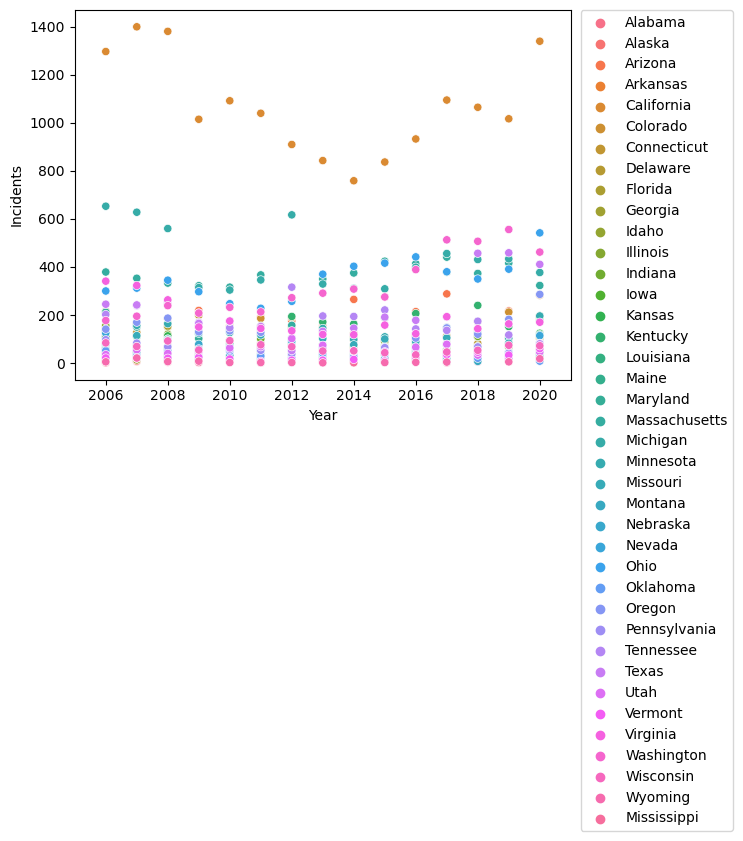

In [107]:
# Plot scatter plot Incidents X Year
ax = sns.scatterplot(data=table, x='Year', y='Incidents', hue='State')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlim(2005,2021)
plt.show()

In [108]:
# Print reg model variables, coefficient, and intercept
def run_regression(input, train, test, output):
    X_train = train[input]
    X_test = test[input]
    y_train = train[output]
    y_test = test[output]
    reg = LinearRegression().fit(X_train, y_train)

    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)

    print('variables: '+str(input))
    print('coefficient: '+str(reg.coef_))
    print('intercept: '+str(reg.intercept_))

    train_mse = (np.square(pred_train - y_train)).mean()
    test_mse = (np.square(pred_test - y_test)).mean()
    print('train_rmse: '+ str(math.sqrt(train_mse)))
    print('test_rmse: '+ str(math.sqrt(test_mse)))

    train_mae = (np.abs(pred_train - y_train)).mean()
    test_mae = (np.abs(pred_test - y_test)).mean()
    print('train_mae: '+ str(train_mae))
    print('test_mae: '+ str(test_mae))
    print(' ')

In [109]:
import statsmodels.api as sm
from statsmodels.api import OLS

def sum_reg(input, train, output):
    X_train = train[input]
    y_train = train[output]
    reg = sm.OLS(y_train, X_train).fit()
    print(reg.summary())

In [112]:
# single-variable models and all-variable model
input = ['Temperature', 'Log_Population', 'Log_GDP', 'Is_Covid']
output = 'Incidents'
train, test= train_test_split(table, test_size=0.1, random_state=42)

for i in input:
    sum_reg([i], train, output)

sum_reg(input, train, output)

                                 OLS Regression Results                                
Dep. Variable:              Incidents   R-squared (uncentered):                   0.337
Model:                            OLS   Adj. R-squared (uncentered):              0.336
Method:                 Least Squares   F-statistic:                              264.1
Date:                Thu, 17 Nov 2022   Prob (F-statistic):                    2.65e-48
Time:                        18:01:54   Log-Likelihood:                         -3478.1
No. Observations:                 520   AIC:                                      6958.
Df Residuals:                     519   BIC:                                      6962.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

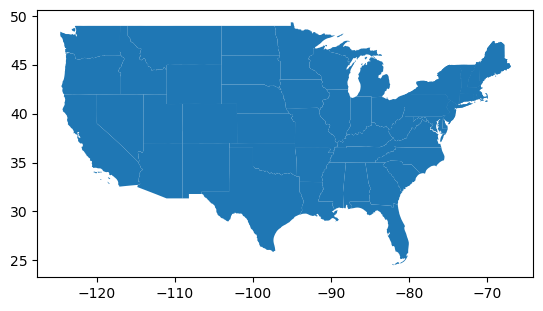

In [111]:
states = geopandas.read_file('geopandas-tutorial/data/usa-states-census-2014.shp')
states.plot()
plt.show()